## Results Productivity

In [1]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard
from src.impact_calculation.impact_heat import *
from src.util.plots import *

fig_dir = '../../data_analysis/figures/'

2020-11-24 16:26:32,224 - climada - DEBUG - Loading default config file: /Users/zeliestalhanske/Documents/GitHub/climada_python/climada/conf/defaults.conf


## Damage cost for each scenario, year and age category

In [8]:
pickle_in = \
open('../../output/mortality_results/impact_100mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

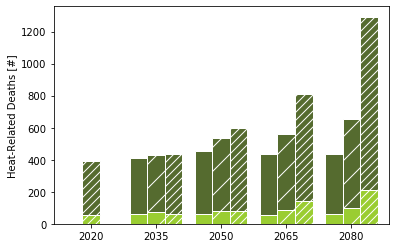

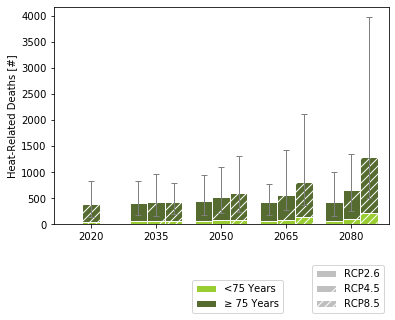

In [9]:
plot_impacts_heat(impacts_mortality.agg_impacts_mc, unit='Heat-Related Deaths [#]', impact_type='mortality', color=['yellowgreen', 'darkolivegreen'], labels_cat=['<75 Years', '≥ 75 Years'], save=True)

In [4]:
def median_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.median(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

def percentile_death(scenario, year, percentile, category='all'):
    if category=='all':
        median_death = (np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'], percentile)+np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75'], percentile))
    else:    
        median_death = np.percentile(impacts_mortality.agg_impacts_mc[scenario][year][category],percentile)
    return median_death

def max_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.max(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

## Spatial Impact

In [3]:
from src.write_entities.define_exposures import *

directory_exposures = '../../input_data/exposures/'
file_info='../../input_data/exposures/age_categories.csv'
file_locations='../../input_data/exposures/STATPOP2018.csv'
shp_cantons='../../input_data/shapefiles/KANTONS_projected_epsg4326/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET_epsg4326.shp'
annual_deaths='../../input_data/impact_functions/annual_deaths.xlsx'

exposures_all = call_exposures_switzerland_mortality(file_info, file_locations, shp_cantons, annual_deaths, population_ratio=False) #number of people instead of ratio

exposures = {}
exposures['Over 75'] = exposures_all[exposures_all['category']=='Over 75']
exposures['Over 75']  = Exposures(exposures['Over 75'] )
exposures['Under 75'] = exposures_all[exposures_all['category']=='Under 75']
exposures['Under 75']  = Exposures(exposures['Under 75'] )

2020-11-23 13:52:11,394 - climada.util.coordinates - INFO - Setting geometry points.
2020-11-23 13:52:58,045 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


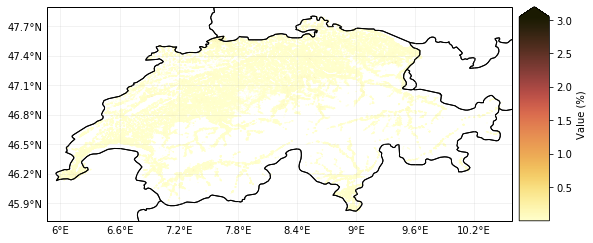

In [39]:
category = 'Over 75'
categories_code = {'Over 75':'O', 'Under 75':'U'}
cm = palettable.scientific.sequential.LaJolla_20.mpl_colormap

impact = impacts_mortality.matrix_as_impact(impacts_mortality.median_impact_matrices['RCP85'][2050][category], exposures[category], unit='%')
impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, extend='max')

#plt.savefig(''.join([fig_dir,'spatial_impact_2050_o75.pdf']),bbox_inches='tight')

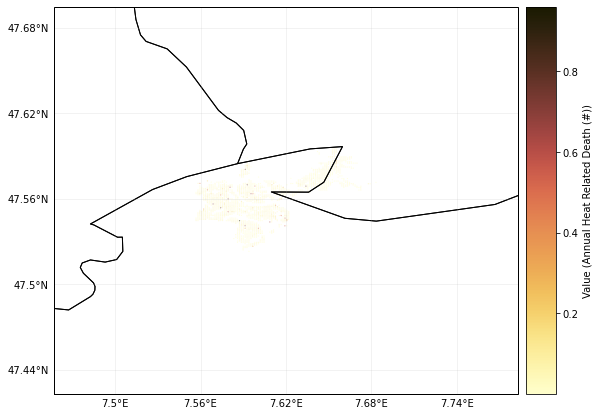

In [6]:
impact = impacts_mortality.matrix_as_impact(median_impact_matrices['RCP85'][2020][category], exposures, unit='Annual Heat Related Death (#)', percentage=False, canton='Basel-Stadt')
impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

## Relative change map

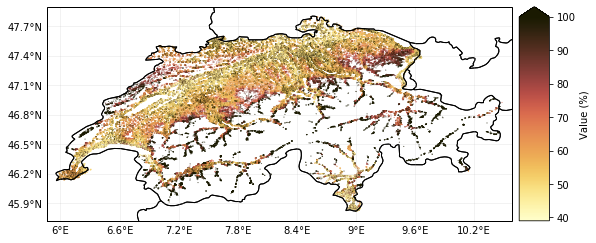

In [17]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP85'][2050][category], impacts_mortality.median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures, unit='%')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=100, extend='max')

#plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75.pdf']),bbox_inches='tight')

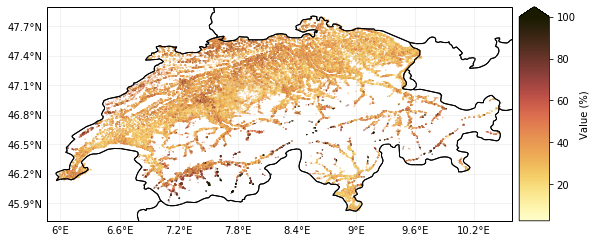

In [19]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP26'][2050][category], impacts_mortality.median_impact_matrices['RCP26'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures, unit='%')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=100, extend='max')

#plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75.pdf']),bbox_inches='tight')

## Canton Impacts

In [51]:
pickle_in = \
open('../../output/mortality_results/impact_100mc2.pickle','rb')
impacts_mortality = pickle.load(pickle_in)
impacts_mortality.years = [2020,2035,2050,2065,2080]
impacts_mortality.categories = ['Under 75','Over 75']
directory_exposures = '../../input_data/exposures/'
exposures = {}
for code, category in {'O': 'Over 75', 'U': 'Under 75'}.items():    
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', code,'.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
    #exposures[category] = Exposures(exposures[category])
    exposures[category].check()

agg_impact_zurich = impacts_mortality.calculate_impact_agg_canton('Ticino', exposures, impacts_mortality.categories)


2020-11-12 18:30:23,928 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5
2020-11-12 18:30:26,008 - climada.entity.exposures.base - INFO - centr_ not set.
2020-11-12 18:30:26,009 - climada.entity.exposures.base - INFO - deductible not set.
2020-11-12 18:30:26,009 - climada.entity.exposures.base - INFO - cover not set.
2020-11-12 18:30:26,010 - climada.entity.exposures.base - INFO - category_id not set.
2020-11-12 18:30:26,010 - climada.entity.exposures.base - INFO - region_id not set.
2020-11-12 18:30:26,012 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_U.h5
2020-11-12 18:30:28,232 - climada.entity.exposures.base - INFO - centr_ not set.
2020-11-12 18:30:28,233 - climada.entity.exposures.base - INFO - deductible not set.
2020-11-12 18:30:28,233 - climada.entity.exposures.base - INFO - cover not set.
2020-11-12 18:30:28,234 - climada.entity.exposures.base - INFO - category_id not s

In [53]:
np.sum(impacts_mortality.median_impact_matrices['RCP85'][2050]['Under 75'])


133.71833210096258

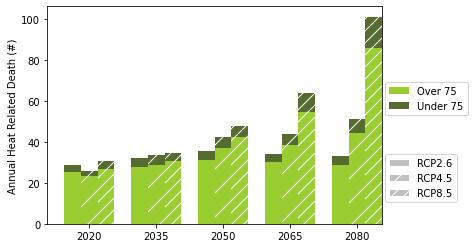

In [9]:
plot_impacts_heat(agg_impact_zurich, 'Annual Heat Related Death (#)', uncertainty=False, color=['yellowgreen', 'darkolivegreen'])



## Make Table with Cantonal Values

In [3]:
pickle_in = \
open('../../output/mortality_results/impact_100mc2.pickle','rb')
impacts_mortality = pickle.load(pickle_in)
impacts_mortality.years = [2020,2035,2050,2065,2080]

directory_exposures = '../../input_data/exposures/'
exposures = {}
for code, category in {'O': 'Over 75', 'U': 'Under 75'}.items():
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', code, '.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
   # exposures[category] = exposures[category][exposures[category]['canton'] == 'Zürich']
    exposures[category] = Exposures(exposures[category])
    exposures[category].check()
    
categories_short = {'Under 75':'<75', 'Over 75':'≥75'}    
cantonal_impacts_df = impacts_mortality.cantonal_impacts_df(exposures, scenarios=['RCP26', 'RCP85'], years=[2020,2050,2080], categories_short=categories_short)


2020-11-24 16:27:03,472 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5
2020-11-24 16:27:05,531 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-11-24 16:27:05,532 - climada.entity.exposures.base - INFO - centr_ not set.
2020-11-24 16:27:05,533 - climada.entity.exposures.base - INFO - deductible not set.
2020-11-24 16:27:05,533 - climada.entity.exposures.base - INFO - cover not set.
2020-11-24 16:27:05,534 - climada.entity.exposures.base - INFO - category_id not set.
2020-11-24 16:27:05,534 - climada.entity.exposures.base - INFO - region_id not set.
2020-11-24 16:27:05,536 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_U.h5
2020-11-24 16:27:07,501 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-11-24 16:27:07,502 - climada.entity.exposures.base - INFO - cen

In [4]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df.astype(int).to_latex(multicolumn=True))


\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} & \multicolumn{6}{l}{RCP2.6} & \multicolumn{6}{l}{RCP8.5} \\
{} & \multicolumn{2}{l}{2020} & \multicolumn{2}{l}{2050} & \multicolumn{2}{l}{2080} & \multicolumn{2}{l}{2020} & \multicolumn{2}{l}{2050} & \multicolumn{2}{l}{2080} \\
{} &    ≥75 & <75 &  ≥75 & <75 &  ≥75 & <75 &    ≥75 & <75 &  ≥75 &  <75 &   ≥75 &  <75 \\
canton                 &        &     &      &     &      &     &        &     &      &      &       &      \\
\midrule
Aargau                 &     12 &   1 &   16 &   2 &   15 &   2 &     11 &   2 &   17 &    4 &    38 &    9 \\
Appenzell Ausserrhoden &      4 &   0 &    5 &   0 &    6 &   0 &      4 &   0 &    8 &    0 &    15 &    2 \\
Appenzell Innerrhoden  &      4 &   0 &    5 &   0 &    5 &   0 &      4 &   0 &    7 &    0 &    14 &    1 \\
Basel-Landschaft       &     17 &   2 &   22 &   3 &   22 &   3 &     16 &   2 &   25 &    5 &    53 &   13 \\
Basel-Stadt            &     54 &  12 &   69 &  16 &   66 &  17 &     52 